In [ ]:
!pip install qiskit

In [ ]:
!pip install qiskit-ibm-runtime

In [ ]:
!pip install pylatexenc

In [ ]:
# General imports
import numpy as np
import random
from qiskit import QuantumCircuit,  QuantumRegister, ClassicalRegister, transpile

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# Quantum circuit simulators
from qiskit.primitives import Estimator, Sampler, BackendSampler
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke

# Parameterized circuit
from qiskit.circuit import Parameter

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram

SparsePauliOp(['IZZ', 'ZZI', 'IIX', 'IXI', 'XII'],
              coeffs=[ 1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j])

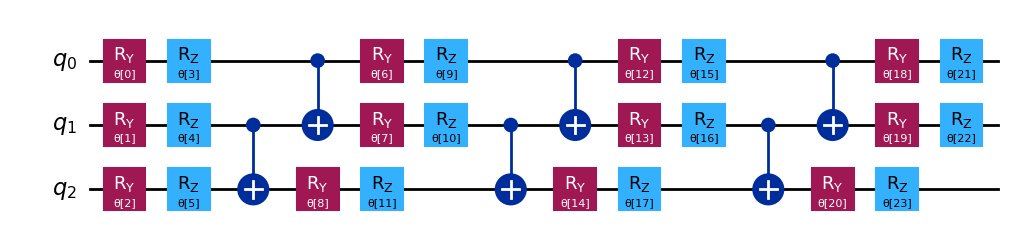

In [ ]:
# Define Spin-1/2 Hamiltonian and Variational Ansatz
num_sites = 3
J = 1
h = -1

oplist = []
for i in range(num_sites-1):
    oplist.append(("ZZ",[i,i+1],J))
for i in range(num_sites):
    oplist.append(("X",[i],h))

hamiltonian = SparsePauliOp.from_sparse_list([*oplist], num_qubits=num_sites)
display(hamiltonian)
ansatz = EfficientSU2(hamiltonian.num_qubits)
display(ansatz.decompose().draw("mpl", style="iqp"))
num_params = ansatz.num_parameters

In [ ]:
# Defien free energy calculation to be minimize based on ansatz parameters
def cost_func(params, ansatz, tr_rho2, tr_rho3, hamiltonian, beta, estimator, sampler):
    free_energy = 0

    # Expectation value of H
    energy = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    free_energy += energy-3/(2*beta)


    # backend = FakeSherbrooke()
    # shots = int(1e4)
    # with np.errstate(divide="ignore", invalid="ignore"):
    #     trans_BVs = transpile(bv_all, backend, optimization_level=3)
    counts = sampler.run(tr_rho2, parameter_values=params, skip_transpilation=True).result().get_counts()
    # Calculation and post-processing of Tr(rho^2)
    #job2 = sampler.run(tr_rho2, parameter_values=params).result()
    R2 = job2.quasi_dists[0][0] - job2.quasi_dists[0][1]
    free_energy += (2/beta)*R2

    # Calculation and post-processing of Tr(rho^3)
    job3 = sampler.run(tr_rho3, parameter_values=params).result()
    R3 = job3.quasi_dists[0][0] - job3.quasi_dists[0][1]
    free_energy += (-1/(2*beta))*R3

    return free_energy

In [ ]:
# Define
def build_callback(ansatz, tr_rho2, tr_rho3, hamiltonian, beta, estimator, sampler, callback_dict):
    def callback(current_vector):
        # Keep track of the number of iterations
        callback_dict["iters"] += 1
        # Set the prev_vector to the latest one
        callback_dict["prev_vector"] = current_vector
        # Compute the value of the cost function at the current vector
        # This adds an additional function evaluation
        current_cost = (
            cost_func(current_vector, ansatz, tr_rho2, tr_rho3, hamiltonian, beta, estimator, sampler)
        )
        callback_dict["cost_history"].append(current_cost)
        # Print to screen on single line
        print(
            "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
            end="\r",
            flush=True,
        )

    return callback

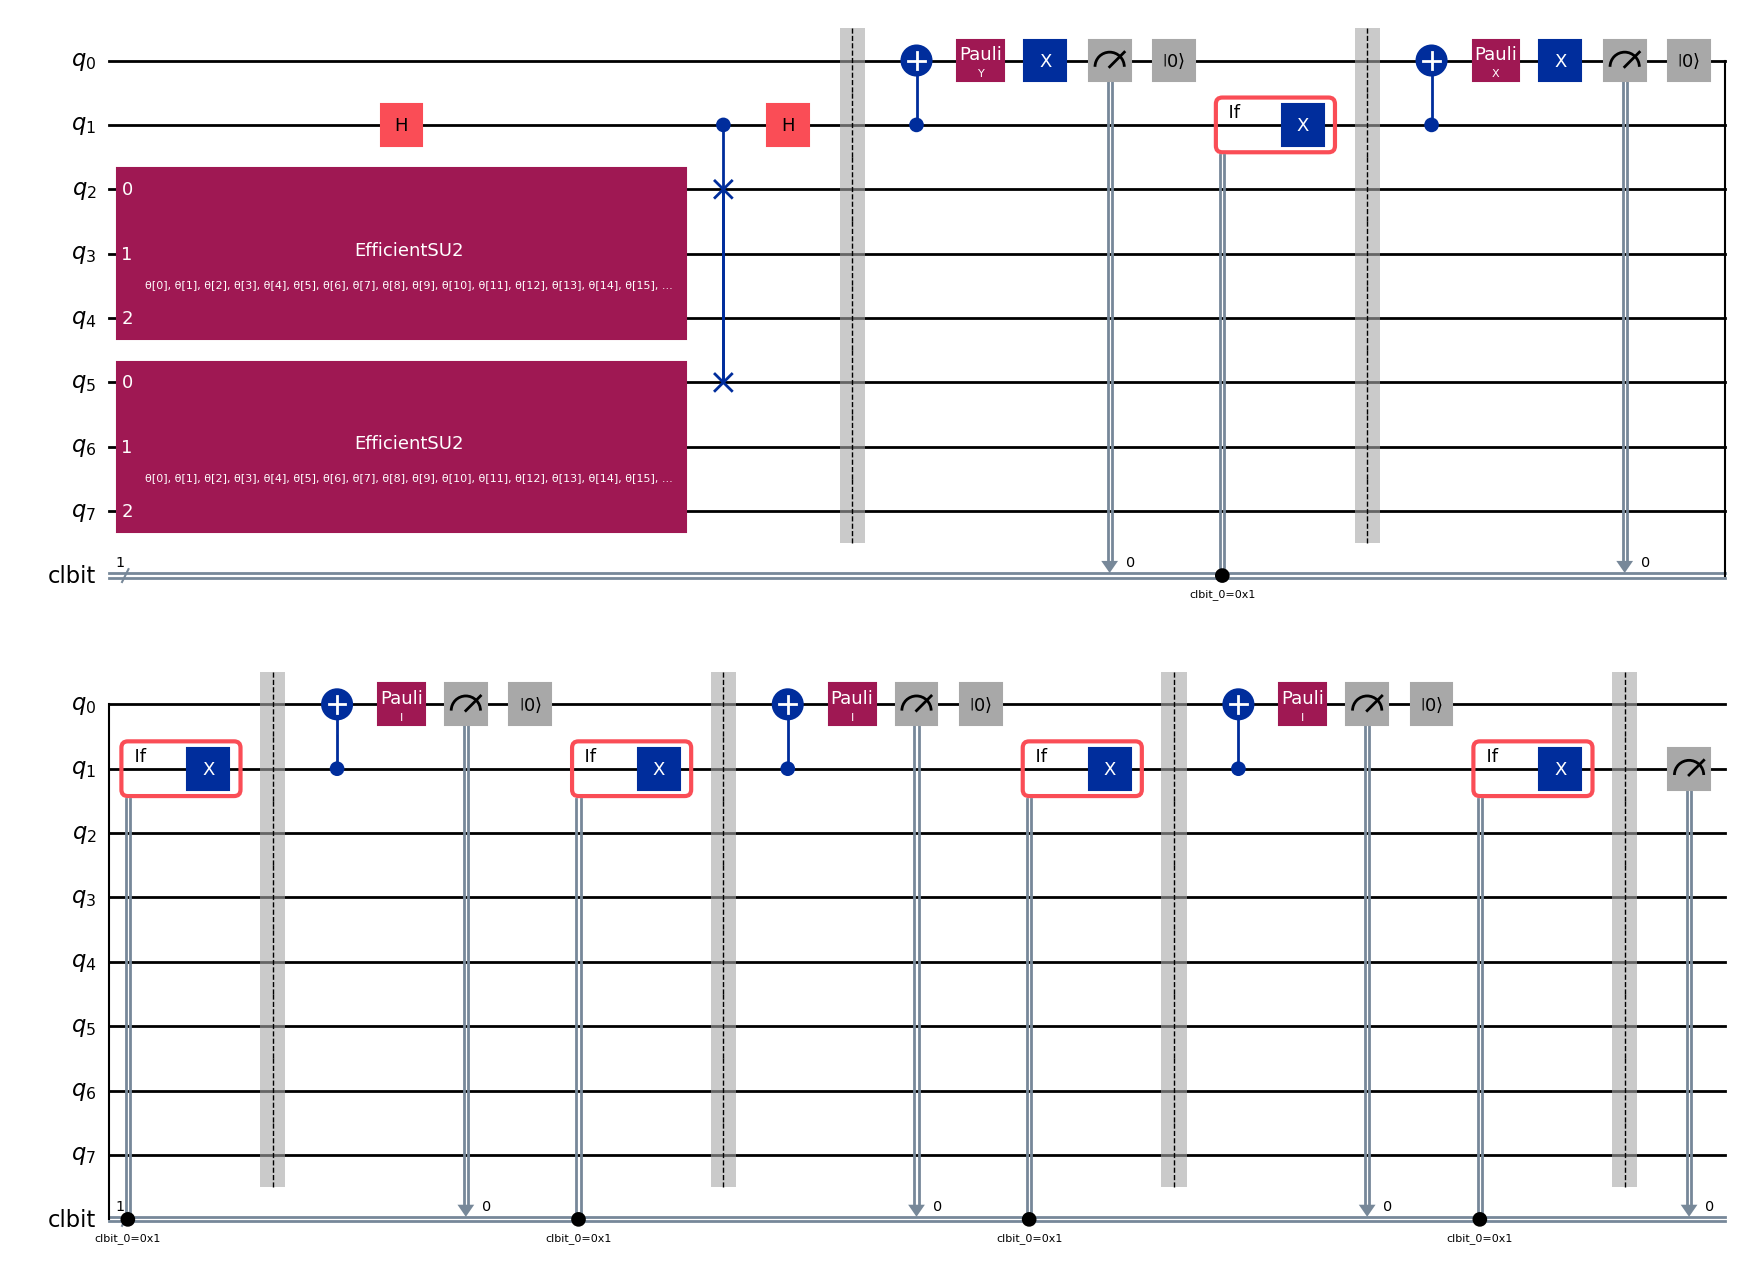

In [ ]:
# Define SWAP test circuit used in Tr(rho^2) calcultion

qubits = QuantumRegister(2)
clbits = ClassicalRegister(1,'clbit')

auxs = QuantumCircuit(qubits,clbits)

tr_rho2 = QuantumCircuit(2*num_sites+2)
tr_rho2 = tr_rho2.compose(auxs, [0,1])
tr_rho2.compose(ansatz, [i+2 for i in range(num_sites)], inplace=True)
tr_rho2.compose(ansatz, [i+2+num_sites for i in range(num_sites)], inplace=True)
tr_rho2.h(1)
tr_rho2.cswap(1,2,num_sites+2)
tr_rho2.h(1)

tr_rho2.barrier()

N = 5
pauli_list = ['I','X','Y','Z']
for i in range(N):
    tr_rho2.cx(1,0)
    rand_pauli = random.choice(pauli_list)
    tr_rho2.pauli(rand_pauli,[0])
    if rand_pauli == 'X' or rand_pauli == 'Y':
        tr_rho2.x(0)
    tr_rho2.measure(0,0)
    tr_rho2.reset(0)
    with tr_rho2.if_test((0, 1)):
        tr_rho2.x(1)
    tr_rho2.barrier()

tr_rho2.measure(1,0)

display(tr_rho2.draw("mpl", style="iqp"))


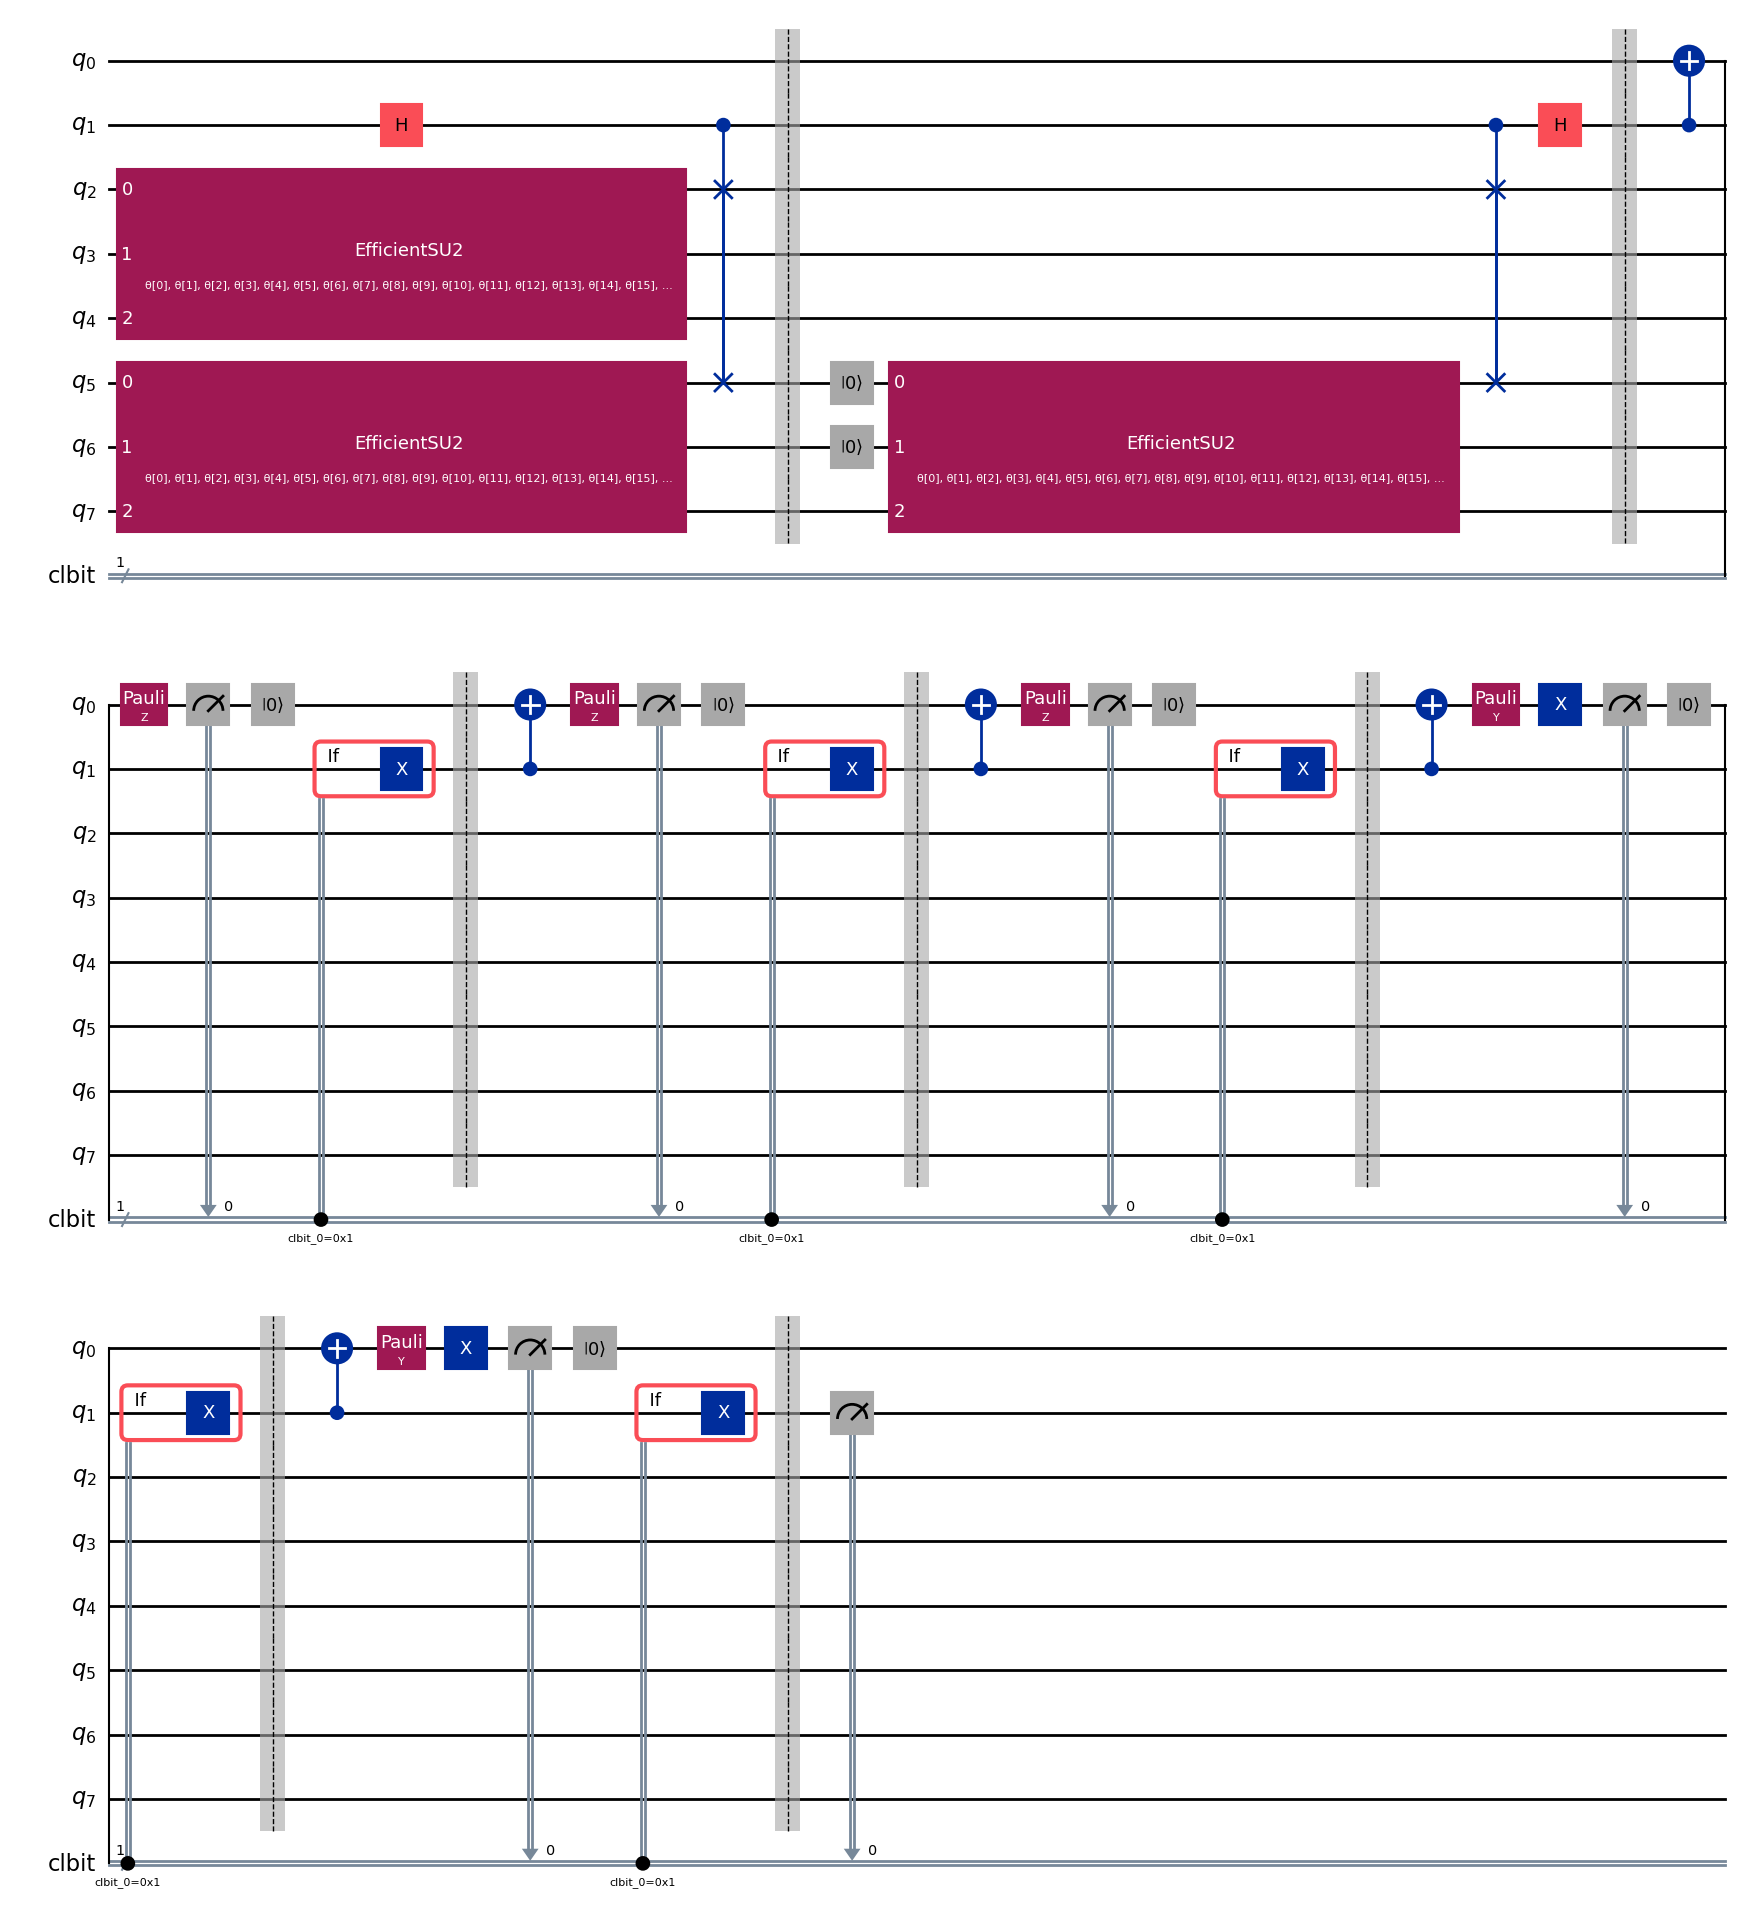

In [ ]:
# Define SWAP test circuit used in Tr(rho^3) calcultion using mid-circuit measurment and reset
qubits = QuantumRegister(2)
clbits = ClassicalRegister(1,'clbit')

auxs = QuantumCircuit(qubits,clbits)

tr_rho3 = QuantumCircuit(2*num_sites+2)
tr_rho3 = tr_rho3.compose(auxs, [0,1])
tr_rho3.compose(ansatz, [i+2 for i in range(num_sites)], inplace=True)
tr_rho3.compose(ansatz, [i+2+num_sites for i in range(num_sites)], inplace=True)
tr_rho3.h(1)
tr_rho3.cswap(1,2,num_sites+2)
tr_rho3.barrier()
tr_rho3.reset([2+num_sites,3+num_sites])
tr_rho3.compose(ansatz, [i+2+num_sites for i in range(num_sites)], inplace=True)
tr_rho3.cswap(1,2,num_sites+2)
tr_rho3.h(1)

tr_rho3.barrier()
N = 5
pauli_list = ['I','X','Y','Z']
for i in range(N):
    tr_rho3.cx(1,0)
    rand_pauli = random.choice(pauli_list)
    tr_rho3.pauli(rand_pauli,[0])
    if rand_pauli == 'X' or rand_pauli == 'Y':
        tr_rho3.x(0)
    tr_rho3.measure(0,0)
    tr_rho3.reset(0)
    with tr_rho3.if_test((0, 1)):
        tr_rho3.x(1)
    tr_rho3.barrier()

tr_rho3.measure(1,0)

display(tr_rho3.draw("mpl", style="iqp"))

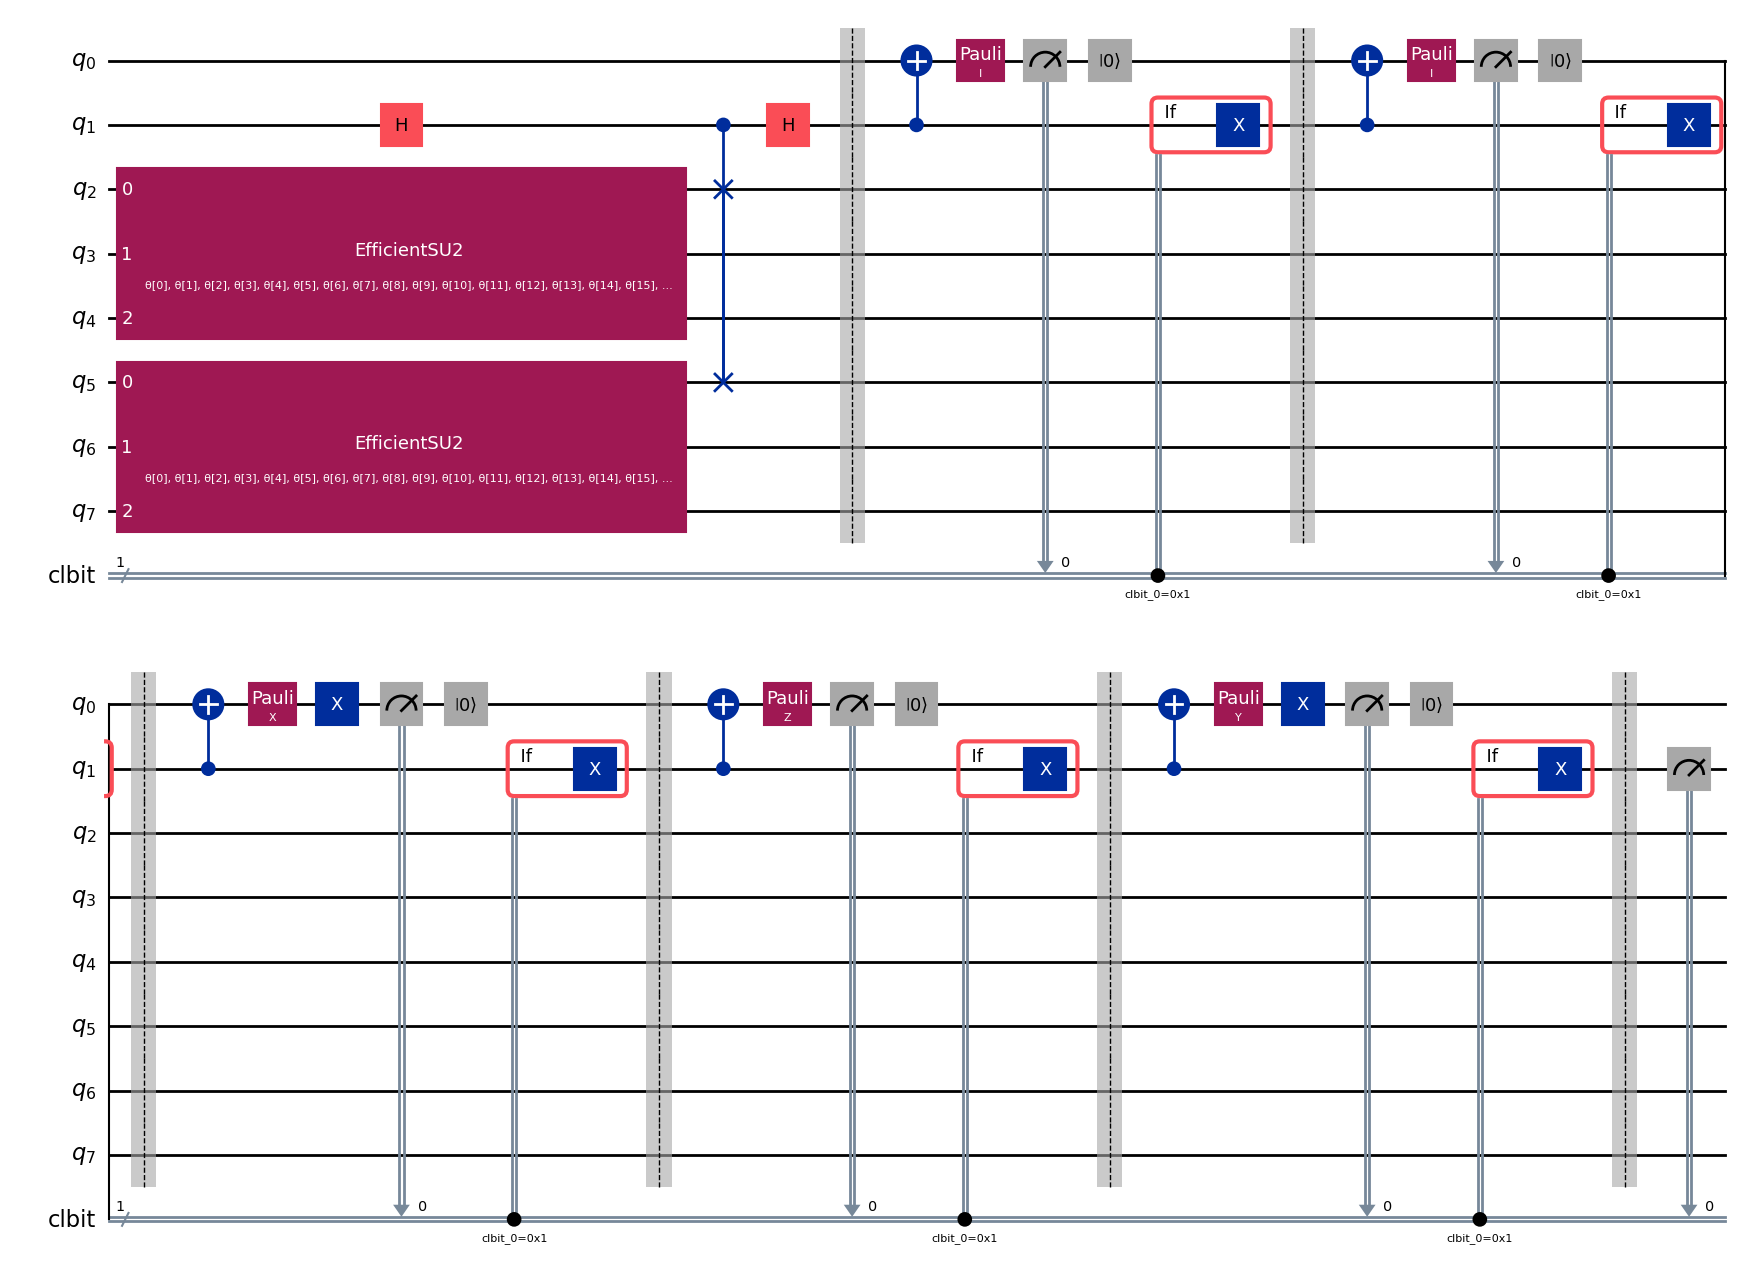

In [ ]:
# Define SWAP test circuit used in Tr(rho^2) calculation with error mitigation techniques

# Initialize quantum and classical registers
qubits = QuantumRegister(2)
clbits = ClassicalRegister(1, 'clbit')

# Create auxiliary circuit for error mitigation
aux_circuit = QuantumCircuit(qubits, clbits)

# Define Tr(rho^2) circuit
tr_rho2 = QuantumCircuit(2*num_sites + 2)

# Compose the auxiliary circuit with Tr(rho^2) circuit
tr_rho2 = tr_rho2.compose(aux_circuit, [0, 1])

# Compose the first ansatz circuit
tr_rho2.compose(ansatz, [i+2 for i in range(num_sites)], inplace=True)

# Compose the second ansatz circuit
tr_rho2.compose(ansatz, [i+2+num_sites for i in range(num_sites)], inplace=True)

# Apply Hadamard gate to qubit 1
tr_rho2.h(1)

# Apply controlled-swap gate
tr_rho2.cswap(1, 2, num_sites+2)

# Apply Hadamard gate to qubit 1
tr_rho2.h(1)

# Insert a barrier for clarity
tr_rho2.barrier()

# Number of Pauli gates to insert
N = 5
pauli_list = ['I', 'X', 'Y', 'Z']

# Insert Pauli gates randomly before measurements
for i in range(N):
    tr_rho2.cx(1, 0)
    rand_pauli = random.choice(pauli_list)
    tr_rho2.pauli(rand_pauli, [0])
    if rand_pauli == 'X' or rand_pauli == 'Y':
        tr_rho2.x(0)
    tr_rho2.measure(0, 0)
    tr_rho2.reset(0)
    with tr_rho2.if_test((0, 1)):
        tr_rho2.x(1)
    tr_rho2.barrier()

# Measure qubit 1
tr_rho2.measure(1, 0)

# Display the Tr(rho^2) circuit
display(tr_rho2.draw("mpl", style="iqp"))


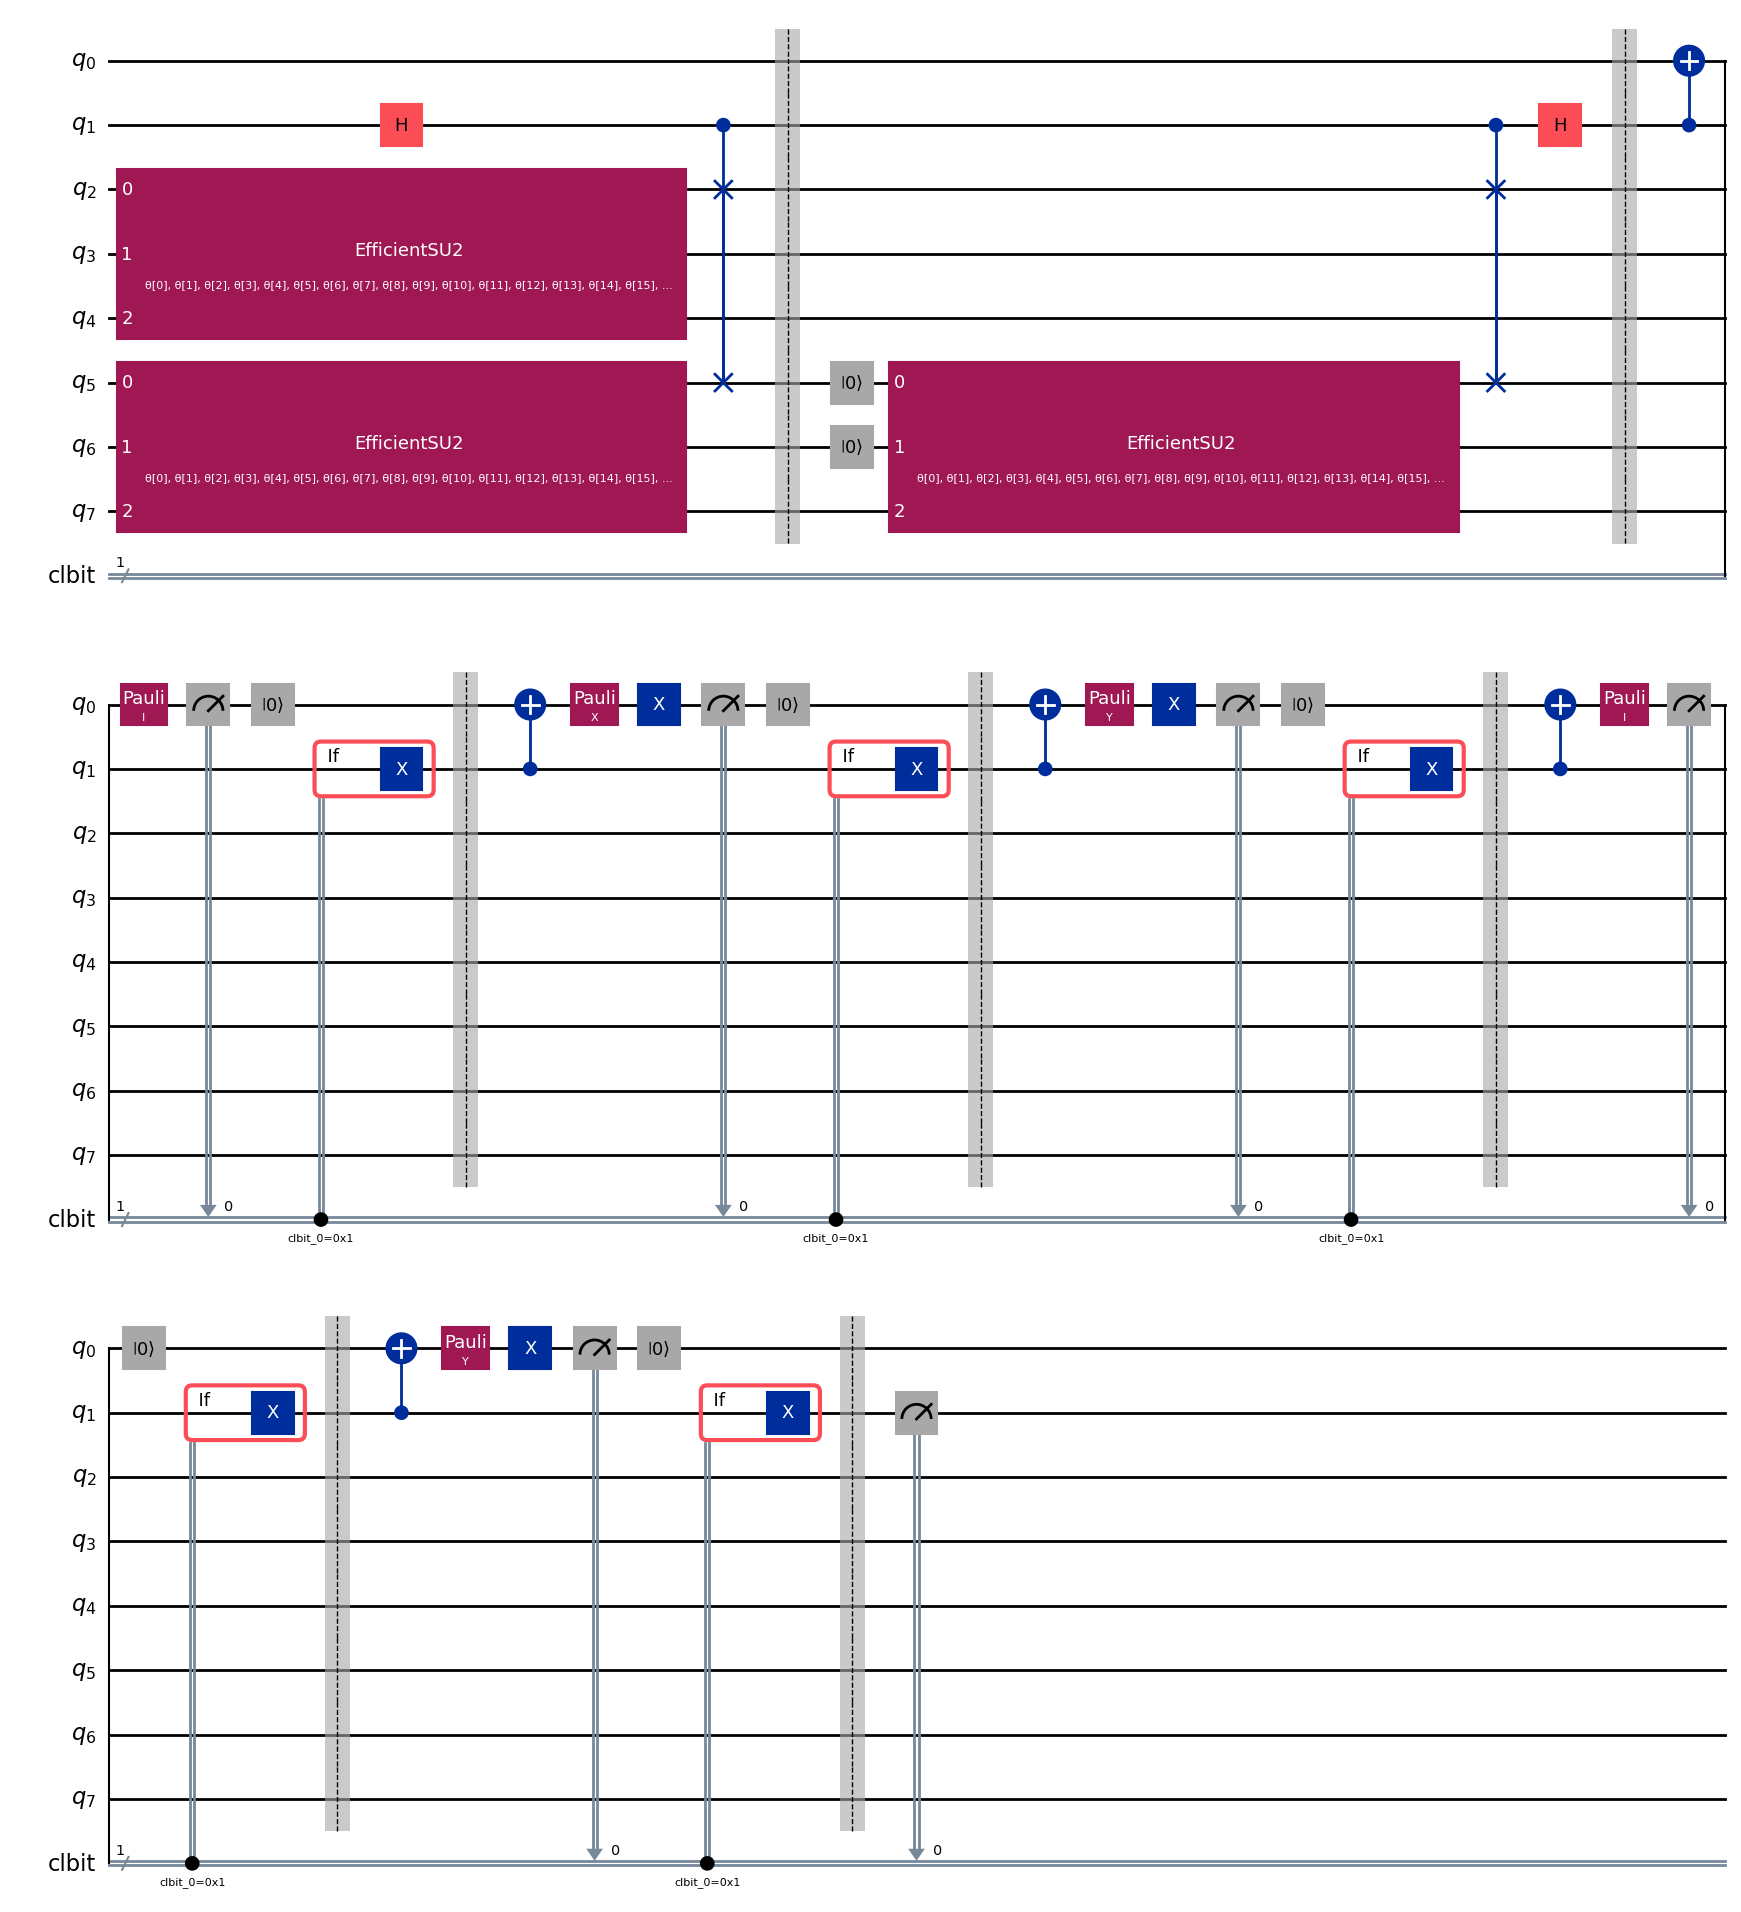

In [ ]:
# Define SWAP test circuit used in Tr(rho^3) calculation with error mitigation techniques

# Initialize quantum and classical registers
qubits = QuantumRegister(2)
clbits = ClassicalRegister(1, 'clbit')

# Create auxiliary circuit for error mitigation
aux_circuit = QuantumCircuit(qubits, clbits)

# Define Tr(rho^3) circuit
tr_rho3 = QuantumCircuit(2*num_sites + 2)

# Compose the auxiliary circuit with Tr(rho^3) circuit
tr_rho3 = tr_rho3.compose(aux_circuit, [0, 1])

# Compose the first ansatz circuit
tr_rho3.compose(ansatz, [i+2 for i in range(num_sites)], inplace=True)

# Compose the second ansatz circuit
tr_rho3.compose(ansatz, [i+2+num_sites for i in range(num_sites)], inplace=True)

# Apply Hadamard gate to qubit 1
tr_rho3.h(1)

# Apply controlled-swap gate
tr_rho3.cswap(1, 2, num_sites+2)

# Insert a barrier for clarity
tr_rho3.barrier()

# Reset qubits 3 and 4
tr_rho3.reset([2+num_sites, 3+num_sites])

# Compose the second ansatz circuit again
tr_rho3.compose(ansatz, [i+2+num_sites for i in range(num_sites)], inplace=True)

# Apply controlled-swap gate again
tr_rho3.cswap(1, 2, num_sites+2)

# Apply Hadamard gate to qubit 1
tr_rho3.h(1)

# Insert a barrier for clarity
tr_rho3.barrier()

# Number of Pauli gates to insert
N = 5
pauli_list = ['I', 'X', 'Y', 'Z']

# Insert Pauli gates randomly before measurements
for i in range(N):
    tr_rho3.cx(1, 0)
    rand_pauli = random.choice(pauli_list)
    tr_rho3.pauli(rand_pauli, [0])
    if rand_pauli == 'X' or rand_pauli == 'Y':
        tr_rho3.x(0)
    tr_rho3.measure(0, 0)  # <-- This line is causing the error
    tr_rho3.reset(0)
    with tr_rho3.if_test((0, 1)):
        tr_rho3.x(1)
    tr_rho3.barrier()

# Measure qubit 1
tr_rho3.measure(1, 0)

# Display the Tr(rho^3) circuit
display(tr_rho3.draw("mpl", style="iqp"))


In [ ]:
# Insert Pauli gates randomly before measurements
for i in range(N):
    tr_rho3.cx(1, 0)
    rand_pauli = random.choice(pauli_list)
    tr_rho3.pauli(rand_pauli, [0])
    if rand_pauli == 'X' or rand_pauli == 'Y':
        tr_rho3.x(0)
    tr_rho3.measure(0, 0)
    tr_rho3.reset(0)
    with tr_rho3.if_test((0, 1)):
        tr_rho3.x(1)
    tr_rho3.barrier()

# Measure qubit 1
tr_rho3.measure(1, 0)


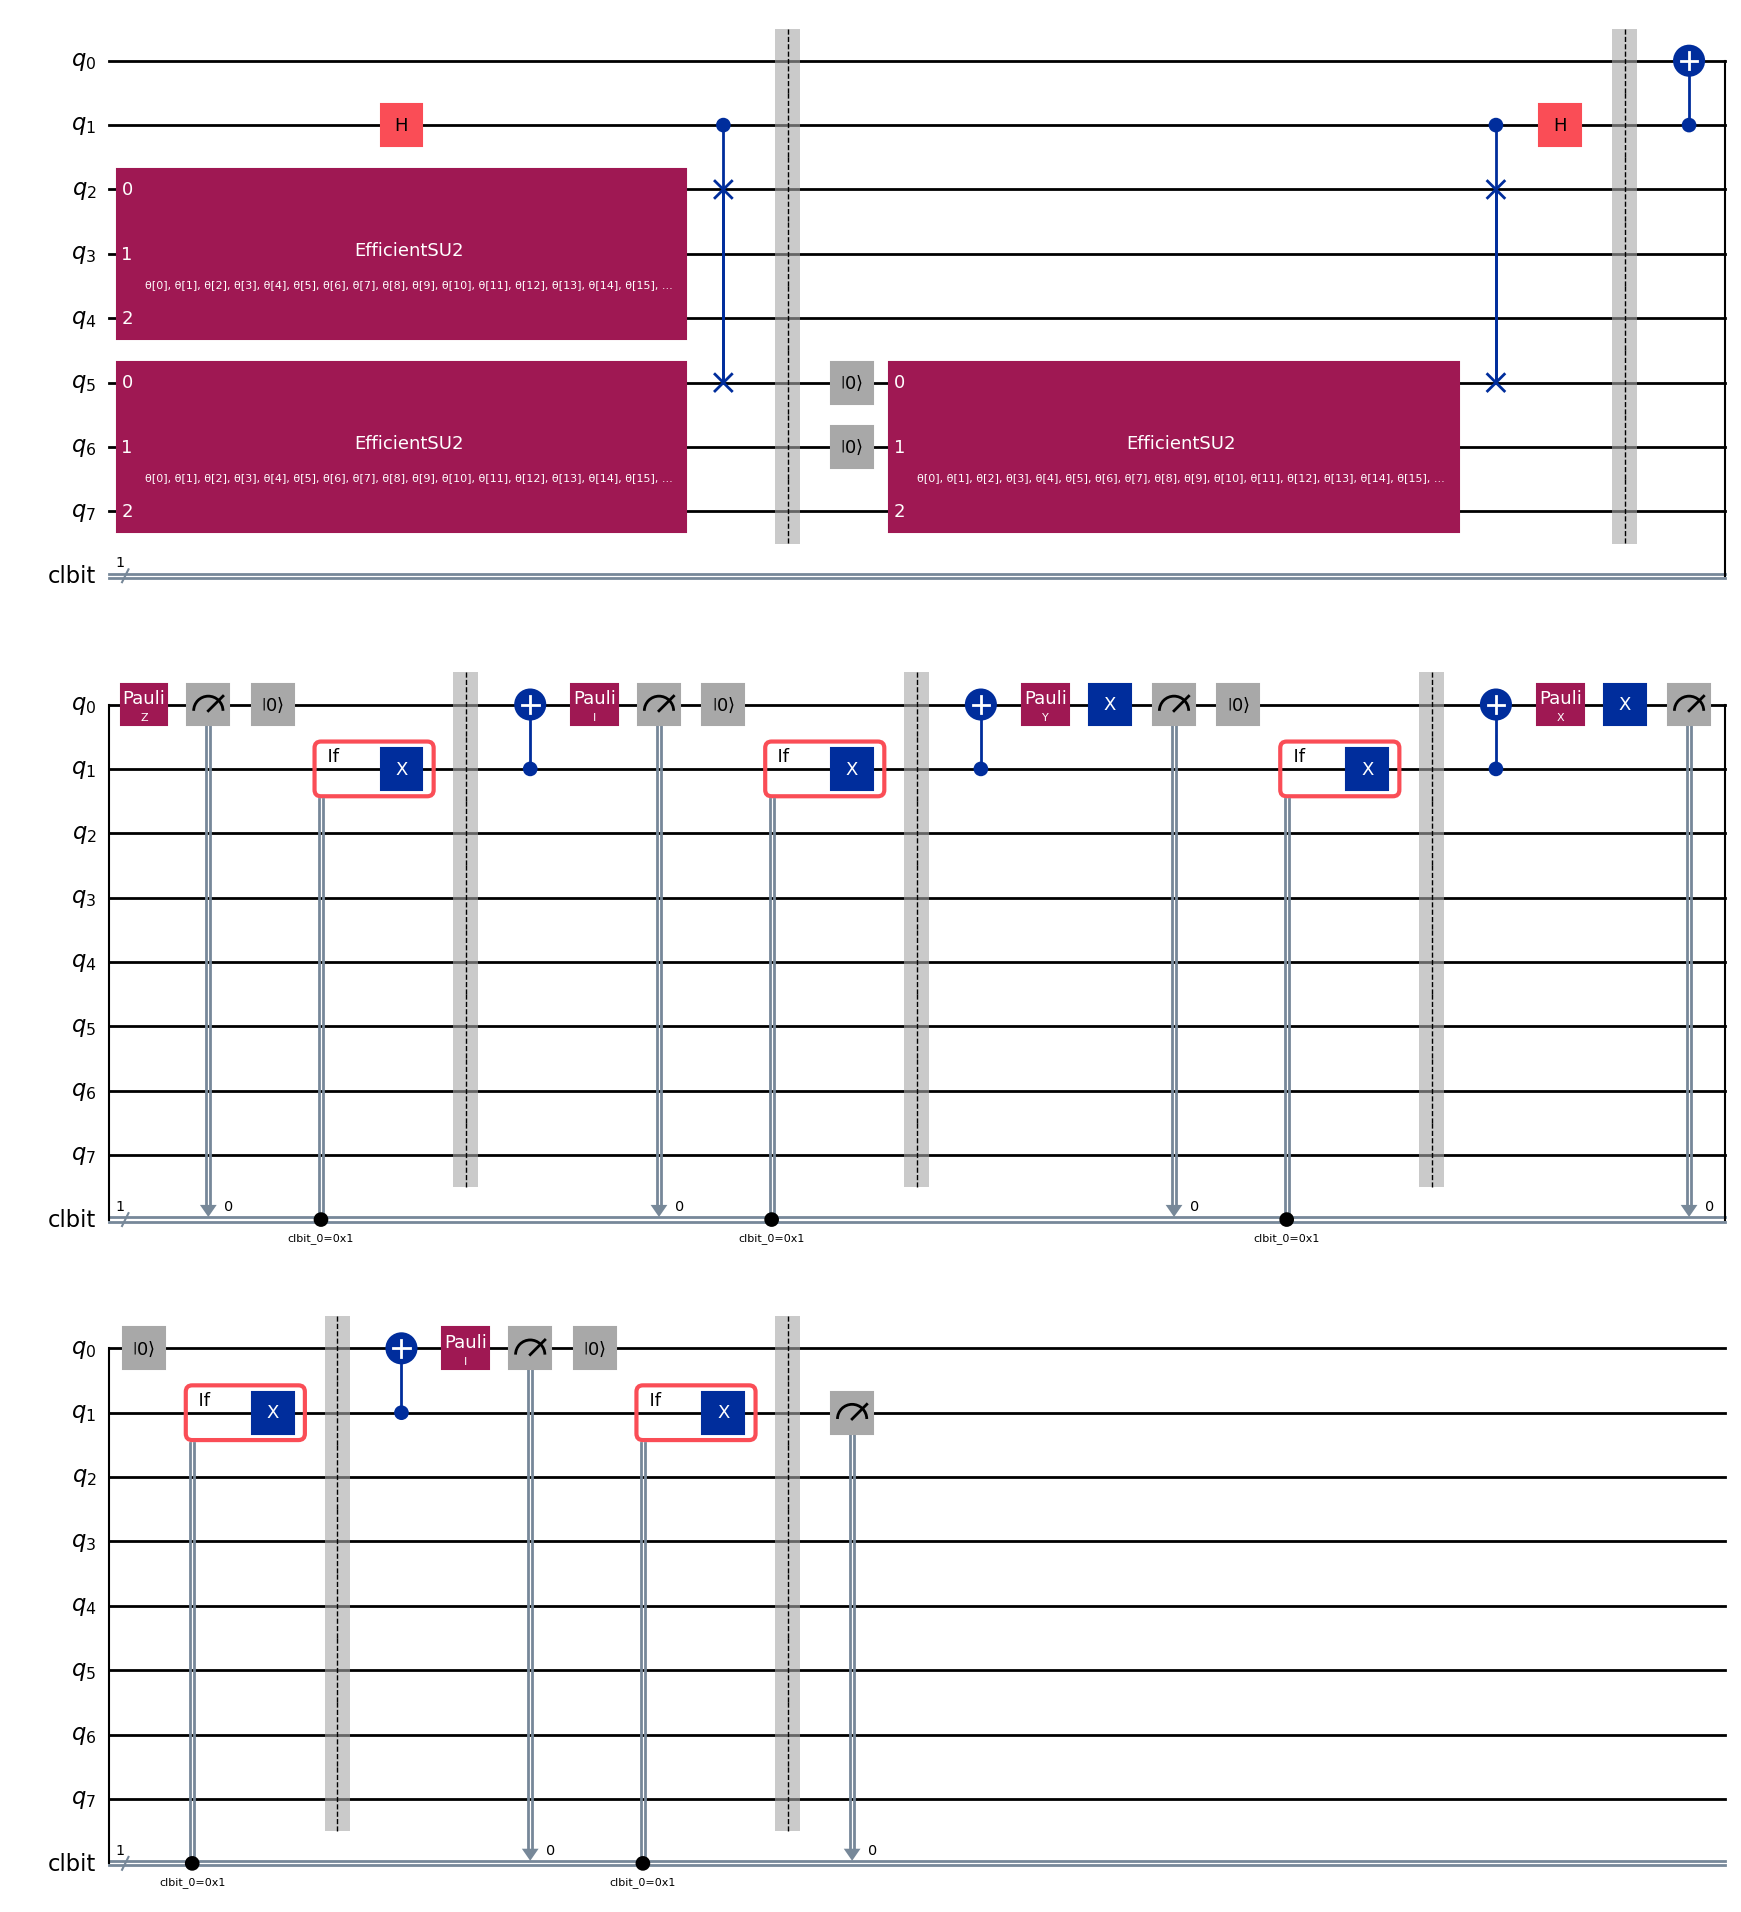

In [ ]:
# Define SWAP test circuit used in Tr(rho^3) calculation with error mitigation techniques

# Initialize quantum and classical registers
qubits = QuantumRegister(2)
clbits = ClassicalRegister(1, 'clbit')

# Create auxiliary circuit for error mitigation
aux_circuit = QuantumCircuit(qubits, clbits)

# Define Tr(rho^3) circuit
tr_rho3 = QuantumCircuit(2*num_sites + 2)

# Compose the auxiliary circuit with Tr(rho^3) circuit
tr_rho3 = tr_rho3.compose(aux_circuit, [0, 1])

# Compose the first ansatz circuit
tr_rho3.compose(ansatz, [i+2 for i in range(num_sites)], inplace=True)

# Compose the second ansatz circuit
tr_rho3.compose(ansatz, [i+2+num_sites for i in range(num_sites)], inplace=True)

# Apply Hadamard gate to qubit 1
tr_rho3.h(1)

# Apply controlled-swap gate
tr_rho3.cswap(1, 2, num_sites+2)

# Insert a barrier for clarity
tr_rho3.barrier()

# Reset qubits 3 and 4
tr_rho3.reset([2+num_sites, 3+num_sites])

# Compose the second ansatz circuit again
tr_rho3.compose(ansatz, [i+2+num_sites for i in range(num_sites)], inplace=True)

# Apply controlled-swap gate again
tr_rho3.cswap(1, 2, num_sites+2)

# Apply Hadamard gate to qubit 1
tr_rho3.h(1)

# Insert a barrier for clarity
tr_rho3.barrier()

# Number of Pauli gates to insert
N = 5
pauli_list = ['I', 'X', 'Y', 'Z']

# Insert Pauli gates randomly before measurements
for i in range(N):
    tr_rho3.cx(1, 0)
    rand_pauli = random.choice(pauli_list)
    tr_rho3.pauli(rand_pauli, [0])
    if rand_pauli == 'X' or rand_pauli == 'Y':
        tr_rho3.x(0)
    tr_rho3.measure(0, 0)  # <-- This line is causing the error
    tr_rho3.reset(0)
    with tr_rho3.if_test((0, 1)):
        tr_rho3.x(1)
    tr_rho3.barrier()

# Measure qubit 1
tr_rho3.measure(1, 0)

# Display the Tr(rho^3) circuit
display(tr_rho3.draw("mpl", style="iqp"))


In [ ]:
# Initialize the fake backend
fake_backend = FakeSherbrooke()

# Initialize the sampler with the fake backend
sampler = BackendSampler(backend=fake_backend)


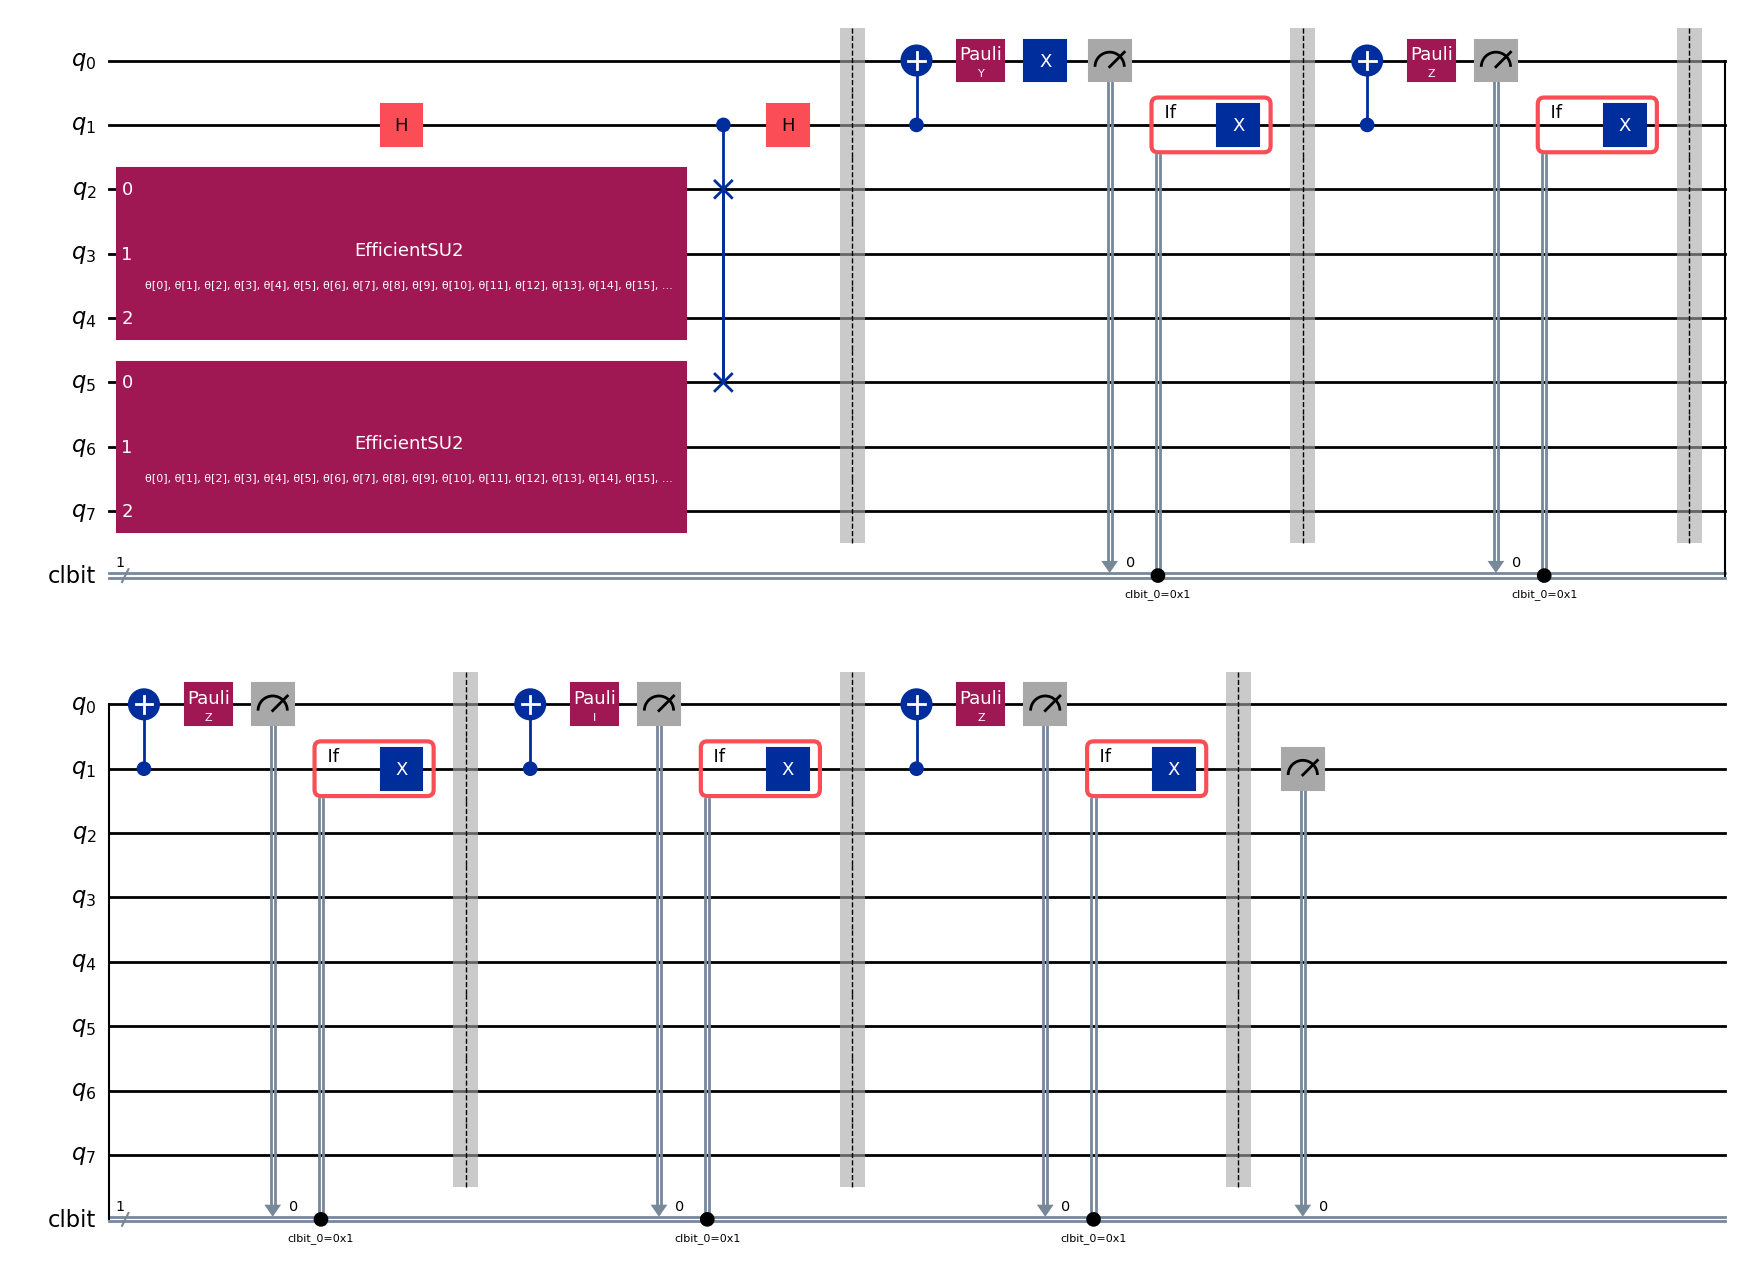

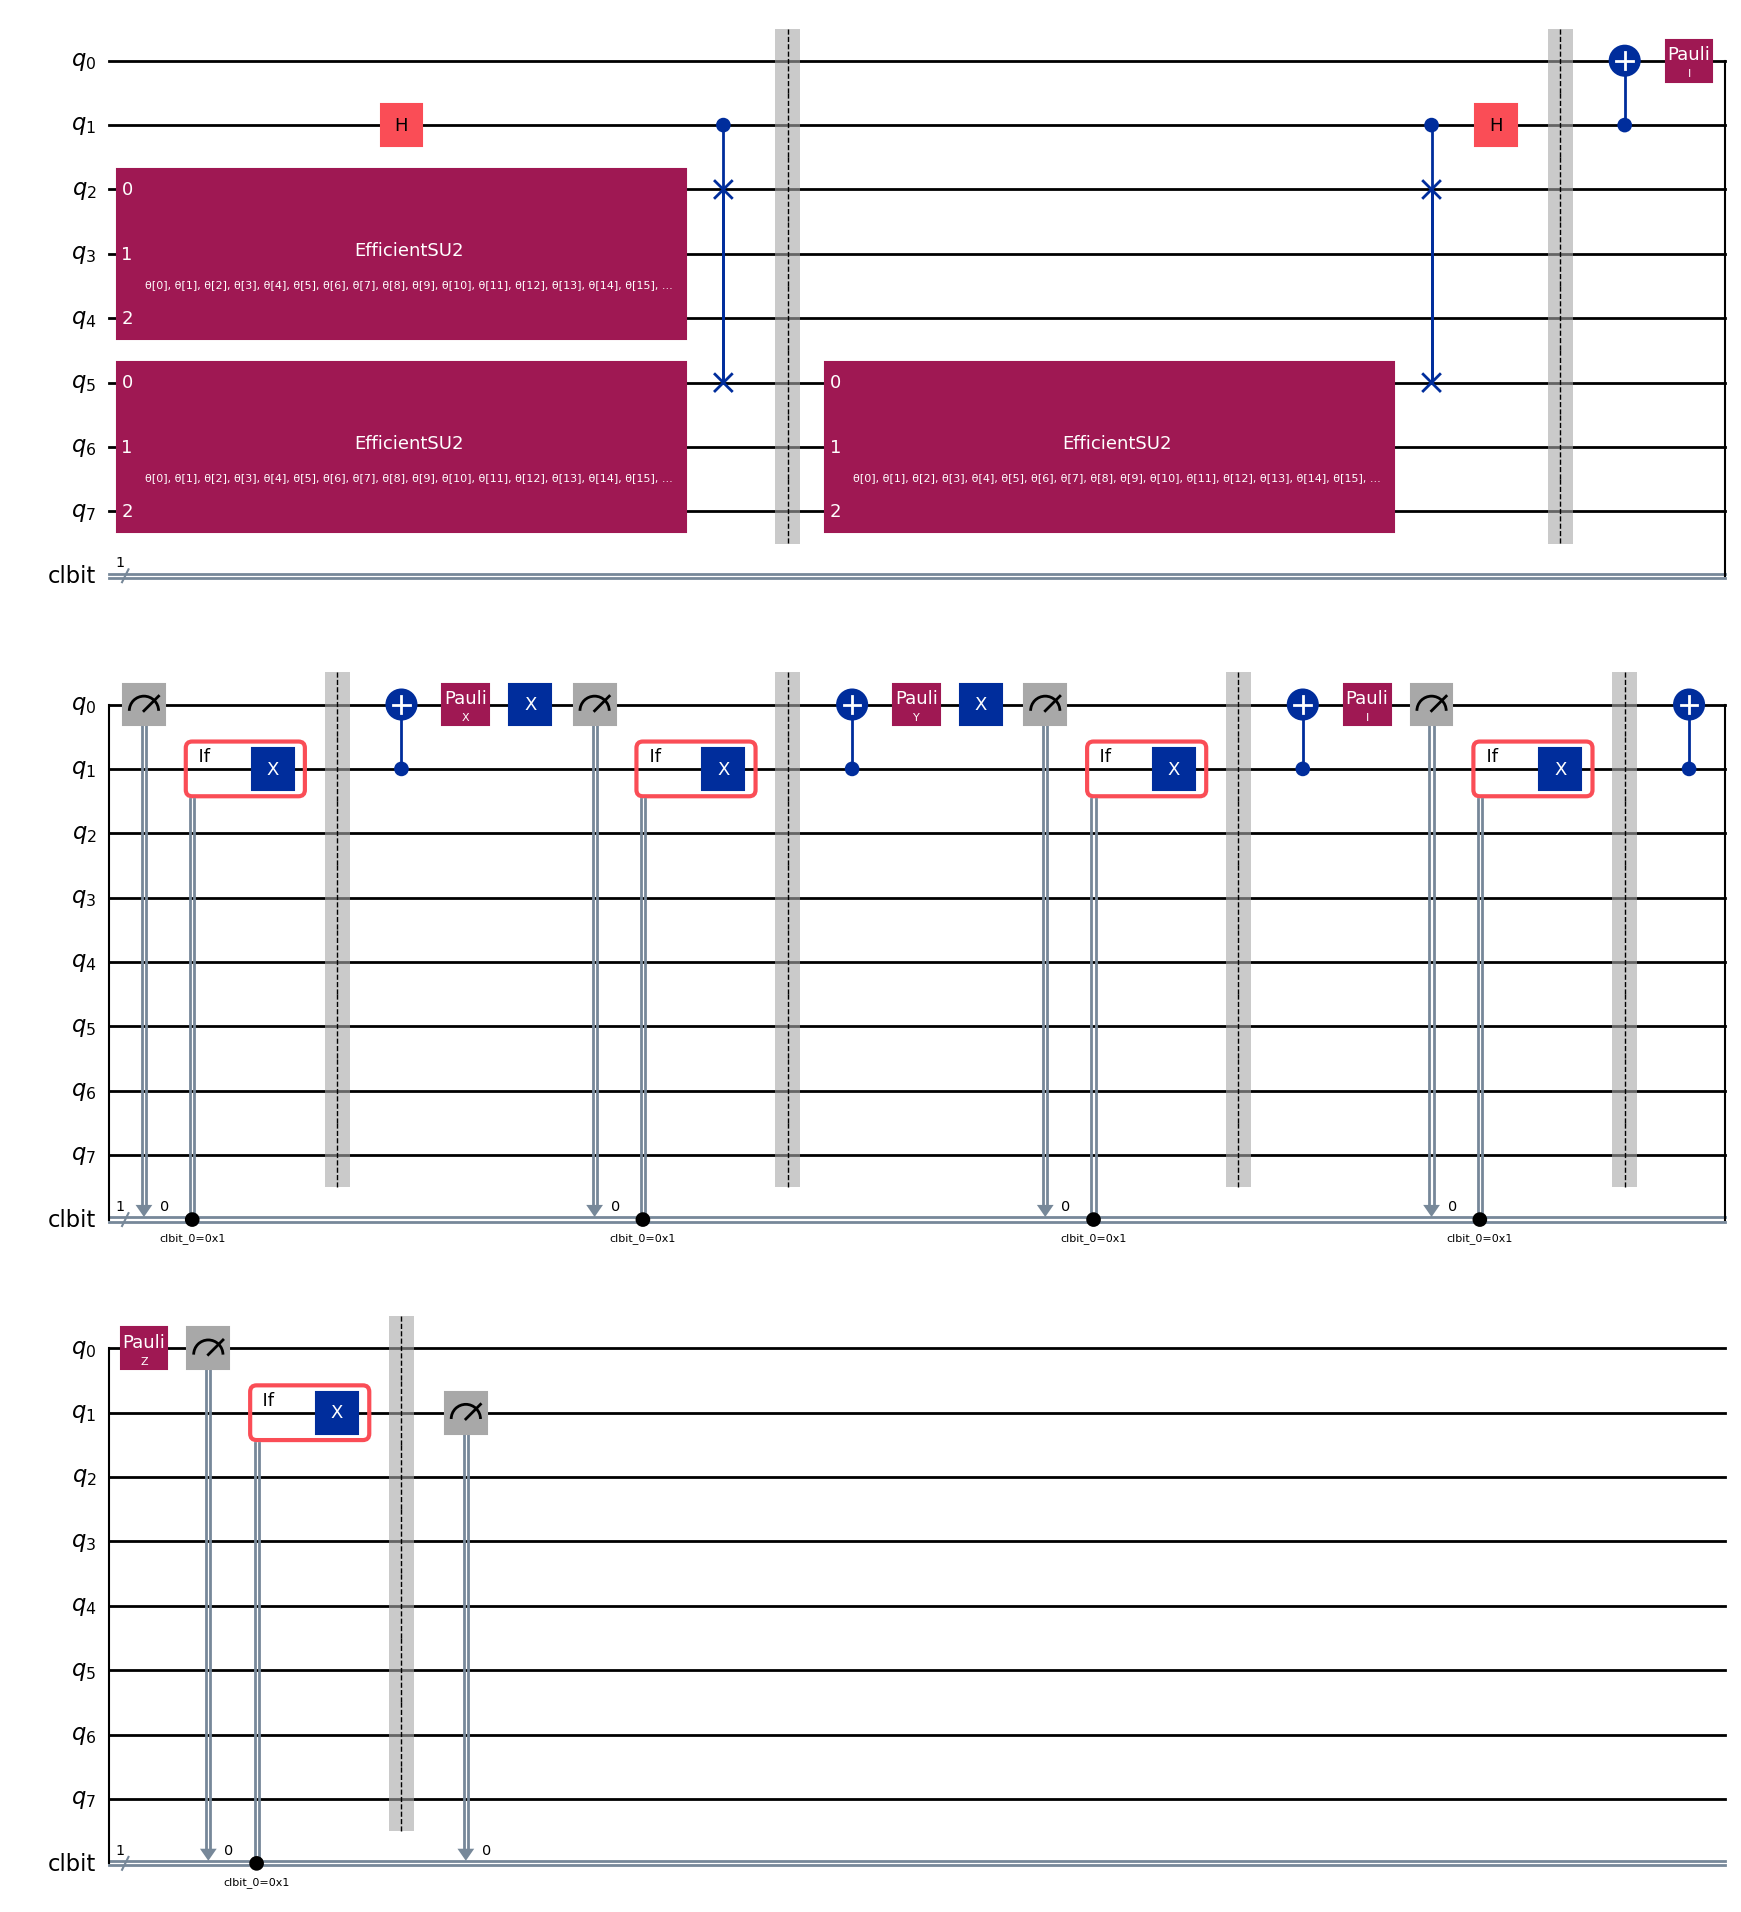

In [ ]:
# Redefine SWAP test circuit used in Tr(rho^2) calculation without using reset
tr_rho2 = QuantumCircuit(2 * num_sites + 2)
tr_rho2 = tr_rho2.compose(auxs, [0, 1])
tr_rho2.compose(ansatz, [i + 2 for i in range(num_sites)], inplace=True)
tr_rho2.compose(ansatz, [i + 2 + num_sites for i in range(num_sites)], inplace=True)
tr_rho2.h(1)
tr_rho2.cswap(1, 2, num_sites + 2)
tr_rho2.h(1)

tr_rho2.barrier()

N = 5
pauli_list = ['I', 'X', 'Y', 'Z']
for i in range(N):
    tr_rho2.cx(1, 0)
    rand_pauli = random.choice(pauli_list)
    tr_rho2.pauli(rand_pauli, [0])
    if rand_pauli == 'X' or rand_pauli == 'Y':
        tr_rho2.x(0)
    tr_rho2.measure(0, 0)
    with tr_rho2.if_test((0, 1)):
        tr_rho2.x(1)
    tr_rho2.barrier()

tr_rho2.measure(1, 0)

# Display the modified circuit
display(tr_rho2.draw("mpl", style="iqp"))


# Redefine SWAP test circuit used in Tr(rho^3) calculation without using reset
tr_rho3 = QuantumCircuit(2 * num_sites + 2)
tr_rho3 = tr_rho3.compose(auxs, [0, 1])
tr_rho3.compose(ansatz, [i + 2 for i in range(num_sites)], inplace=True)
tr_rho3.compose(ansatz, [i + 2 + num_sites for i in range(num_sites)], inplace=True)
tr_rho3.h(1)
tr_rho3.cswap(1, 2, num_sites + 2)
tr_rho3.barrier()
tr_rho3.compose(ansatz, [i + 2 + num_sites for i in range(num_sites)], inplace=True)
tr_rho3.cswap(1, 2, num_sites + 2)
tr_rho3.h(1)

tr_rho3.barrier()
N = 5
pauli_list = ['I', 'X', 'Y', 'Z']
for i in range(N):
    tr_rho3.cx(1, 0)
    rand_pauli = random.choice(pauli_list)
    tr_rho3.pauli(rand_pauli, [0])
    if rand_pauli == 'X' or rand_pauli == 'Y':
        tr_rho3.x(0)
    tr_rho3.measure(0, 0)
    with tr_rho3.if_test((0, 1)):
        tr_rho3.x(1)
    tr_rho3.barrier()

tr_rho3.measure(1, 0)

# Display the modified circuit
display(tr_rho3.draw("mpl", style="iqp"))


In [ ]:
def build_callback(ansatz, tr_rho2, tr_rho3, hamiltonian, beta, estimator, execute_circuit, callback_dict):
    def callback(current_vector):
        # Keep track of the number of iterations
        callback_dict["iters"] += 1
        # Set the prev_vector to the latest one
        callback_dict["prev_vector"] = current_vector
        # Compute the value of the cost function at the current vector
        # This adds an additional function evaluation
        current_cost = (
            cost_func(current_vector, ansatz, tr_rho2, tr_rho3, hamiltonian, beta, estimator, execute_circuit)
        )
        callback_dict["cost_history"].append(current_cost)
        # Print to screen on single line
        print(
            "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
            end="\r",
            flush=True,
        )

    return callback


In [ ]:
callback = build_callback(ansatz, tr_rho2, tr_rho3, hamiltonian, beta, estimator, execute_circuit, callback_dict)


In [ ]:
def build_callback(ansatz, tr_rho2, tr_rho3, hamiltonian, beta, estimator, execute_circuit, callback_dict):
    def callback(current_vector):
        # Keep track of the number of iterations
        callback_dict["iters"] += 1
        # Set the prev_vector to the latest one
        callback_dict["prev_vector"] = current_vector
        # Compute the value of the cost function at the current vector
        # This adds an additional function evaluation
        current_cost = (
            cost_func(current_vector, ansatz, tr_rho2, tr_rho3, hamiltonian, beta, estimator, execute_circuit)
        )
        callback_dict["cost_history"].append(current_cost)
        # Print to screen on single line
        print(
            "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
            end="\r",
            flush=True,
        )

    return callback


In [ ]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}
callback = build_callback(ansatz, tr_rho2, tr_rho3, hamiltonian, beta, estimator, execute_circuit, callback_dict)


In [ ]:
def build_callback(ansatz, tr_rho2, tr_rho3, hamiltonian, beta, estimator, sampler, callback_dict):
    def callback(current_vector):
        # Keep track of the number of iterations
        callback_dict["iters"] += 1
        # Set the prev_vector to the latest one
        callback_dict["prev_vector"] = current_vector
        # Compute the value of the cost function at the current vector
        # This adds an additional function evaluation
        current_cost = (
            cost_func(current_vector, ansatz, tr_rho2, tr_rho3, hamiltonian, beta, estimator, sampler)
        )
        callback_dict["cost_history"].append(current_cost)
        # Print to screen on single line
        print(
            "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
            end="\r",
            flush=True,
        )

    return callback


In [ ]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}
callback = build_callback(ansatz, tr_rho2, tr_rho3, hamiltonian, beta, estimator, sampler, callback_dict)


In [ ]:
def cost_func(params, ansatz, tr_rho2, tr_rho3, hamiltonian, beta, estimator):
    free_energy = 0

    # Expectation value of H
    energy = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    free_energy += energy - 3 / (2 * beta)

    # Calculation and post-processing of Tr(rho^2)
    tr_rho2_result = estimator.run(tr_rho2, parameter_values=params).result()
    R2 = tr_rho2_result.expectation
    free_energy += (2 / beta) * R2

    # Calculation and post-processing of Tr(rho^3)
    tr_rho3_result = estimator.run(tr_rho3, parameter_values=params).result()
    R3 = tr_rho3_result.expectation
    free_energy += (-1 / (2 * beta)) * R3

    return free_energy


In [ ]:
def cost_func(params, ansatz, tr_rho2, tr_rho3, hamiltonian, beta, estimator, sampler):
    free_energy = 0

    # Expectation value of H
    energy = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    free_energy += energy - 3 / (2 * beta)

    # Execute circuits for Tr(rho^2) and Tr(rho^3) using the provided sampler
    counts_rho2 = sampler.run(tr_rho2, parameter_values=params, shots=8192).result().get_counts()
    counts_rho3 = sampler.run(tr_rho3, parameter_values=params, shots=8192).result().get_counts()

    # Calculate and post-process Tr(rho^2) and Tr(rho^3)
    R2 = calculate_R(counts_rho2)
    R3 = calculate_R(counts_rho3)

    free_energy += (2 / beta) * R2 - (1 / (2 * beta)) * R3

    return free_energy


In [ ]:
# Print the number of parameters in the ansatz circuit
print("Number of parameters in the ansatz circuit:", num_params)

# Print the length of the initial parameters array
print("Length of initial parameters array:", len(x0))


Number of parameters in the ansatz circuit: 24
Length of initial parameters array: 24


In [ ]:
import numpy as np
from qiskit.quantum_info import Operator

# Define a function to compute the expectation value of the Hamiltonian
def compute_energy_expectation(ansatz, hamiltonian, parameters):
    # Bind the parameters to the ansatz circuit
    bound_circuit = ansatz.assign_parameters(parameters)

    # Convert the bound circuit to an Operator
    operator = Operator(bound_circuit)

    # Get the state vector after applying the operator
    state_vector = operator.data @ np.array([1] + [0] * (2 ** hamiltonian.num_qubits - 1))

    # Compute the expectation value
    expectation_value = np.dot(state_vector.conj(), hamiltonian.to_matrix() @ state_vector)
    return expectation_value.real

# Initialize parameters
initial_parameters = np.zeros(num_params)

# Compute the energy expectation value
energy_expectation = compute_energy_expectation(ansatz, hamiltonian, initial_parameters)

# Calculate the free energy using the energy expectation value
free_energy = energy_expectation - 3 / (2 * beta)

# Print the calculated free energy
print(f'Calculated Free Energy: {free_energy}')


Calculated Free Energy: 1.0


In [ ]:
from qiskit.quantum_info import Statevector

# Define a reference state (for example, the ground state of the Hamiltonian)
hamiltonian_matrix = hamiltonian.to_matrix()
eigenvalues, eigenvectors = np.linalg.eigh(hamiltonian_matrix)
ground_state_vector = eigenvectors[:, np.argmin(eigenvalues)]
reference_state = Statevector(ground_state_vector)

# Compute the state produced by the ansatz circuit
bound_ansatz_circuit = ansatz.assign_parameters(initial_parameters)
ansatz_state = Statevector.from_instruction(bound_ansatz_circuit)

# Compute the fidelity between the ansatz state and the reference state
fidelity = state_fidelity(ansatz_state, reference_state)
print(f'Fidelity between ansatz state and ground state: {fidelity}')


Fidelity between ansatz state and ground state: 0.04181839960097066
